In [8]:
import re
import string
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer #
from sklearn.feature_extraction.text import TfidfVectorizer #
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB
import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords #
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer 

# make sure stopwords are downloaded
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
tokenizer = RegexpTokenizer(r'[a-zA-Z0-9]+')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\akams\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\akams\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\akams\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Import and load data

In [173]:
xx = pd.read_csv('two_bbc_data.csv')

In [175]:
xx

,Unnamed: 0,recipe,type
0,0,1 ½kg chicken thighs and drumsticks 180g sea s...,american-recipes
1,1,"1 large chicken 5 beef short ribs (about 3kg),...",american-recipes
2,2,"150g unsalted butter , softened 80g golden cas...",american-recipes
3,3,"1 whole chicken , jointed, or 8 bone-in chicke...",american-recipes
4,4,500g macaroni 1l whole milk 2 bay leaves 60g b...,american-recipes
...,...,...,...
895,25,300g/10oz urid dal (black gram) 20g/1oz vegeta...,pakistani
896,26,450g/1lb strong white flour 1 tsp salt 7g sac...,pakistani
897,27,500g/1lb 2oz chopped rhubarb 250g/9oz light so...,pakistani
898,28,250g/½lb gram flour 50g/2oz self-raising flour...,pakistani


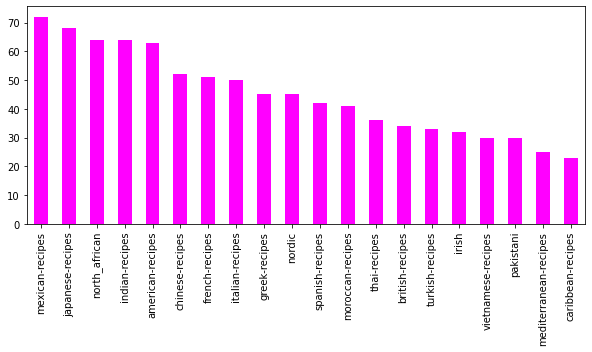

In [176]:
plt.figure(figsize=(10,4))
xx['type'].value_counts().plot(kind='bar', color='magenta')

In [2]:
df = pd.read_csv('final_bbc_data.csv', index_col = 0)
print(df.shape)
df.head()

(900, 2)


,Ingredients,Cuisine
0,1 ½kg chicken thighs and drumsticks 180g sea s...,1
1,"1 large chicken 5 beef short ribs (about 3kg),...",1
2,"150g unsalted butter , softened 80g golden cas...",1
3,"1 whole chicken , jointed, or 8 bone-in chicke...",1
4,500g macaroni 1l whole milk 2 bay leaves 60g b...,1


# Cleaning

In [99]:
# grab specified string from dataframe
def testing_str(index_num):
    read = df['Ingredients'][index_num]
    return read

In [42]:
def shallow_cleaning(_corpus):
    _corpus = _corpus.lower() # lowercase
    _corpus = re.sub('\[.*/()]', '', _corpus) # removes data in brackets
    _corpus = re.sub('[%s]' % re.escape(string.punctuation), '', _corpus) # list of punctuation, get rid of any punctuation
    _corpus = re.sub('\w*\d\w*', '', _corpus) # removes all numbers and any words that comtain them
    return _corpus
# apply the function and assign to variable
shallow_clean = lambda x: shallow_cleaning(x)

In [43]:
shallow_ingredients = pd.DataFrame(df['Ingredients'].apply(shallow_clean))

In [44]:
shallow_ingredients

,Ingredients
0,½kg chicken thighs and drumsticks sea salt f...
1,large chicken beef short ribs about ribs se...
2,unsalted butter softened golden caster suga...
3,whole chicken jointed or bonein chicken pie...
4,macaroni whole milk bay leaves butter pla...
...,...
895,urid dal black gram vegetable oil tsp fresh...
896,strong white flour tsp salt sachet fastact...
897,chopped rhubarb light soft brown sugar tsp...
898,gram flour selfraising flour ½ tsp red chill...


In [26]:
shallow_df = shallow_ingredients.join(df['Cuisine'])

In [59]:
# use regex for deep cleaning
def deep_cleaning(_corpus):
    tokenizer = RegexpTokenizer(r'[a-zA-Z0-9]+')
    tokenized_corpus = tokenizer.tokenize(_corpus)
    n_corpus = ' '.join(tokenized_corpus) 
    return n_corpus
# apply the function and assign to variable
deep_clean = lambda x: deep_cleaning(x)

In [62]:
deep_ingredients = pd.DataFrame(shallow_df['Ingredients'].apply(deep_clean))

In [64]:
deep_df = deep_ingredients.join(df['Cuisine'])

In [67]:
deep_df

,Ingredients,Cuisine
0,kg chicken thighs and drumsticks sea salt flak...,1
1,large chicken beef short ribs about ribs separ...,1
2,unsalted butter softened golden caster sugar l...,1
3,whole chicken jointed or bonein chicken pieces...,1
4,macaroni whole milk bay leaves butter plain fl...,1
...,...,...
895,urid dal black gram vegetable oil tsp freshly ...,20
896,strong white flour tsp salt sachet fastaction ...,20
897,chopped rhubarb light soft brown sugar tsp van...,20
898,gram flour selfraising flour tsp red chilli po...,20


In [128]:
def nltk_stopwords(string):
    stop_words = set(stopwords.words('english'))
    tokenized_string = tokenizer.tokenize(string)
    cleaned_string = [word for word in tokenized_string if word not in stop_words]
    new_str = ' '.join(cleaned_string)
    return new_str

remove_nltks = lambda x: nltk_stopwords(x)

def custom_stopwords(string):
    custom_stop_words = ['oz', 'lb', 'lbs', 'g', 'kg', 'gram', 'grams', 'cm', 'inch', 'ounce', 'pound', 'tsp', 'tbsp', 'small', 'medium', 'large']
    tokenized_string = tokenizer.tokenize(string)
    cleaned_string = [word for word in tokenized_string if word not in custom_stop_words]
    new_str = ' '.join(cleaned_string)
    return new_str 

remove_customs = lambda x: custom_stopwords(x)

In [133]:
custom_ings = pd.DataFrame(deep_df['Ingredients'].apply(remove_customs))

In [134]:
rmv_custom_df = custom_ings.join(df['Cuisine'])

In [136]:
nltk_ings = pd.DataFrame(rmv_custom_df['Ingredients'].apply(remove_nltks))

In [137]:
df2 = nltk_ings.join(df['Cuisine'])

In [138]:
df2

,Ingredients,Cuisine
0,chicken thighs drumsticks sea salt flakes soft...,1
1,chicken beef short ribs ribs separated piece b...,1
2,unsalted butter softened golden caster sugar e...,1
3,whole chicken jointed bonein chicken pieces us...,1
4,macaroni whole milk bay leaves butter plain fl...,1
...,...,...
895,urid dal black vegetable oil freshly grated gi...,20
896,strong white flour salt sachet fastaction drie...,20
897,chopped rhubarb light soft brown sugar vanilla...,20
898,flour selfraising flour red chilli powder gara...,20


# Organizing

In [141]:
test2 = df2['Ingredients'][0]

In [144]:
test2 = tokenizer.tokenize(test2)

In [48]:
def plot_fdist(arg, n):
    fdist = FreqDist(arg)
    plt.figure(figsize=(10, 10))
    return fdist.plot(n)

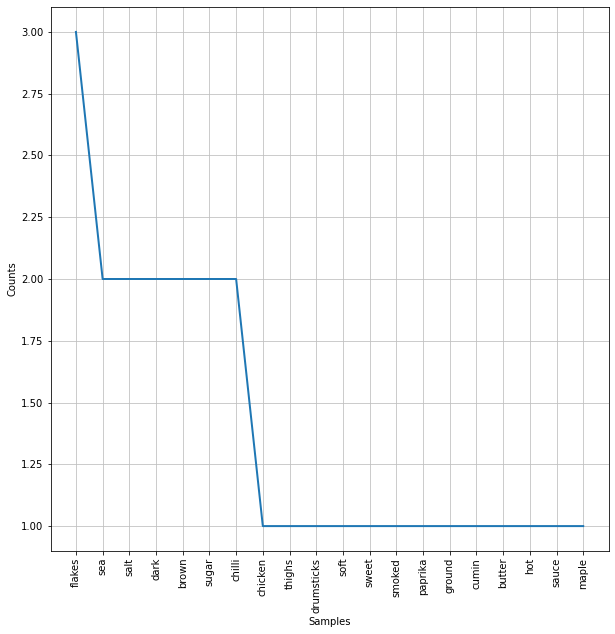

In [145]:
plot_fdist(test2, 20)

**Look into words that make need many of the same ingredient.**

In [167]:
more_words = ['absorbing', 'according', 'action', 'add', 'youre', 'youve', 'zest', 
             'zested']

In [168]:
cv = CountVectorizer(stop_words = more_words, ngram_range = (1,1))
cv_data  = cv.fit_transform(df2['Ingredients'])
df2_tm = pd.DataFrame(cv_data.toarray(), columns = cv.get_feature_names())
df2_tm.index = df2.index
df2_tm

,aberdeen,adam,african,airdried,ale,allbutter,allspice,almond,almonds,along,...,wraps,xylitol,yeast,yellow,yoghurt,yogurt,yolk,yolks,young,yuzu
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
896,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
897,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
898,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [169]:
df2_tm.to_csv('matrix_1.csv')

In [171]:
df2.to_csv('deep_clean_data.csv')

In [54]:
# Stemming: change = chang
from nltk.stem import PorterStemmer
ps = PorterStemmer()

stemmed_read=[]
for w in filtered_read:
    stemmed_read.append(ps.stem(w))

print(stemmed_read)

['1', 'kg', 'chicken', 'thigh', 'drumstick', '180g', 'sea', 'salt', 'flake', '90g', 'soft', 'dark', 'brown', 'sugar', '2', 'tbsp', 'chilli', 'flake', '2', 'tbsp', 'sweet', 'smoke', 'paprika', '1', 'tbsp', 'ground', 'cumin', '1', 'tbsp', 'sea', 'salt', 'flake', '1', 'tbsp', 'dark', 'brown', 'sugar', '75g', 'butter', '125ml', 'hot', 'chilli', 'sauc', '1', 'tbsp', 'mapl', 'syrup']


In [58]:
# lemmatezization: changer = change
from nltk.stem import WordNetLemmatizer 
  
lemmatizer = WordNetLemmatizer() 

lemmatized_read=[]
for w in filtered_read:
    lemmatized_read.append(lemmatizer.lemmatize(w))

print(lemmatized_read)

['1', 'kg', 'chicken', 'thigh', 'drumstick', '180g', 'sea', 'salt', 'flake', '90g', 'soft', 'dark', 'brown', 'sugar', '2', 'tbsp', 'chilli', 'flake', '2', 'tbsp', 'sweet', 'smoked', 'paprika', '1', 'tbsp', 'ground', 'cumin', '1', 'tbsp', 'sea', 'salt', 'flake', '1', 'tbsp', 'dark', 'brown', 'sugar', '75g', 'butter', '125ml', 'hot', 'chilli', 'sauce', '1', 'tbsp', 'maple', 'syrup']
